# Dask Cluster: Analysis of Covid-19 papers 


Nowadays, Big Data has been increasing exponentially, reaching an astounding volume of **181 zettabytes**. This growth has accelerated since around **2010**, when the internet became more accessible to the public. It’s an incredibly powerful asset, especially for large companies—but the real challenge lies in **how to handle it efficiently**.


Unlike traditional datasets, Big Data cannot be handled with standard tools like **NumPy** or **Pandas**, due to limitations in memory capacity. That’s where **Dask** steps in.


**Dask** is an open-source parallel computing library designed for scalable data analysis with two core goals in mind:

1. **Efficient Task Scheduling**: for parallel and distributed computing across single nodes, clusters, or high-performance computing (HPC) environments  


2. **Familiar Big-Data Collections for Python Users**  Extends the capabilities of standard Python tools to Dask Array, Dask DataFrame and DaskBag (similar to numpy, pandas and dictionaries but allow partitions in nodes).


![dask.png](dask.png)


## Cluster Initialization

- SSHCluster: allows to start a Dask cluster across multiple machines (first IP address correspond to the Scheduler and the remaining three to the workers).
- Client: creates a connection to that cluster, enabling us to submit and monitor parallel tasks.

In [48]:
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.248", "10.67.22.108", "10.67.22.245", "10.67.22.92"],
    connect_options={"known_hosts": None},
    scheduler_options={"port": 8793, "dashboard_address": ":8745"}
)

client = Client(cluster)


2025-07-07 20:25:47,887 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:47,886 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 20:25:47,907 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:47,906 - distributed.scheduler - INFO - State start
2025-07-07 20:25:47,910 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:47,909 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.248:8793
2025-07-07 20:25:49,756 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:49,756 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.245:43603'
2025-07-07 20:25:49,775 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:49,776 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.92:34015'
2025-07-07 20:25:50,071 - distributed.deploy.ssh - INFO - 2025-07-07 20:25:50,071 - distributed.diskutils - INFO - Found stale lock file and directory '/t

In [49]:
client

<Client: 'tcp://10.67.22.248:8793' processes=2 threads=16, memory=31.23 GiB>

- We run an small example to observe how the dask paquetery works: we define 3 functions `increment(x)`, `decrement(x)` and `add(x, y)`.
- Dask work through **lazy evaluation** where operations are not executed immediately instead they are delayed and only computed when explicitly requested.
- `delayed()`: Dask builds a task graph of the operations without running them.
- `compute()`: compute operations are only executed when we call .*compute*, allowing Dask to optimize the execution plan for better performance and memory management.

In [50]:
import graphviz
%matplotlib inline

In [51]:
##Verify that the client is connected to the cluster
from dask import delayed
from time import sleep

def increment(x):
    sleep(1)
    return x + 1

x = delayed(increment)(1)

def decrement(x):
    sleep(1)
    return x - 1

y = delayed(decrement)(x)

def add(x, y):
    sleep(1)
    return x + y

result = delayed(add)(x, y)

result.visualize(filename='task_graph', format='png')  #Because we are working with Dask, we do not have an interface to visualize the task graph directly in the notebook. We save it
result.compute()
 


3

![graph](task_graph.png)

In [52]:
##Simple dask bag task 
import dask.bag as db

b = db.from_sequence([{"name": "Alice", "age": 30}, {"name": "Bob", "age": 25}, {"name": "Charlie", "age": 35}])
b.map(lambda x: x["age"]).compute()  

[30, 25, 35]

## Benchmarking file

Prepare the environment for benchmarking the distributed computation, using libraries like `time`, `csv` for measuring performance.

We also indicate the number of partitions.

In [53]:
import os
import pandas as pd
csv_file = 'benchmark_results.csv'

if os.path.exists(csv_file):
    all_benchmark_results = pd.read_csv(csv_file)
else:
    all_benchmark_results = pd.DataFrame(columns=[
        'num_workers','num_partitions',
        'load_data_time', 'clean_count_time', 'extract_full_text_time',
        'embedding_time', 'cosine_sim_bag_time', 'embedding_df_time',
        'convert_to_parquet_time', 'cosine_simM_one_title_time', 'cosine_simM_all_time'
    ])

In [54]:
#Start benchmarking
import time
import csv
partitions= 500     #Number of partitions


## Analysis of Covid-19 papers

The aim of this work is to process **Big Data** related to scientific papers on **COVID-19**.

We utilized data from the [CORD-19 Research Challenge](https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge), version 50, hosted on Kaggle. The files are provided in JSON (semistructured format). With the following structure:

### JSON Schema of Full-Text Documents

```json
{
  "paper_id": <str>,  // 40-character sha1 of the PDF
  "metadata": {
    "title": <str>,
    "authors": [
      {
        "first": <str>,
        "middle": <list of str>,
        "last": <str>,
        "suffix": <str>,
        "affiliation": <dict>,
        "email": <str>
      },
      ...
    ],
    "abstract": [
      {
        "text": <str>,
        "cite_spans": [
          {
            "start": 151,
            "end": 154,
            "text": "[7]",
            "ref_id": "BIBREF3"
          },
          ...
        ],
        "ref_spans": <list of dicts similar to cite_spans>,
        "section": "Abstract"
      },
      ...
    ],
    "body_text": [
      {
        "text": <str>,
        "cite_spans": [],
        "ref_spans": [],
        "eq_spans": [],
        "section": "Introduction"
      },
      ...
      {
        ...,
        "section": "Conclusion"
      }
    ],
    "bib_entries": {
      "BIBREF0": {
        "ref_id": <str>,
        "title": <str>,
        "authors": <list of dict>,
        "year": <int>,
        "venue": <str>,
        "volume": <str>,
        "issn": <str>,
        "pages": <str>,
        "other_ids": {
          "DOI": [
            <str>
          ]
        }
      },
      ...
    },
    "ref_entries": {
      "FIGREF0": {
        "text": <str>,
        "type": "figure"
      },
      ...
      "TABREF13": {
        "text": <str>,
        "type": "table"
      }
    },
    "back_matter": <list of dict>
  }
}


### Bag module

**Dask Bag** is a versatile data structure for working with unstructured or semi-structured data like nested JSON. We can see it as a parallelized Python list, capable of storing any object—including custom classes and complex records—much like PySpark’s RDD.

Dask Bags support common operations (`map`, `filter`, `groupby`, `fold`) in a parallel.

Each Bag is **partitioned** into blocks, making it easy to scale. After processing, data often transitions into more structured formats like **Dask DataFrames** or **Dask Arrays** for further analysis.

Bag rely on the lazy paradigm, data is not stored in the cluster until perform a compute operation.

## Cleaning Functions

At first we need to clean our data, to do this we use the packages:

- `nltk`: allow us the remove common words in English (the, and, or...) and specific words provided by us (corresponding to scientific paper's vocabulary: DOI, fig,...).
- `re`: allow to clean the data, removing punctuation and numbers for sanitizing the text. 

In [55]:
skipwords = ['title','section', 'first', 'middle', 'last','suffix', 'text','bibref', 'start', 'end', 'doi','peerreviewed', 'preprint', 'copyright', 'fig', 'holder', 'authorfunder', 'license', 'httpsdoiorg', 'available', 'figure', 'medrxiv', 'also', 'biorxiv', 'using','may', 'two', 'used', 'expression', 'one'  ]

In [56]:
##Clean the json data, remove stop words 
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(skipwords)

`clean_text`:
- Converts all characters to lowercase
- Removes everything except lowercase letters and spaces
- Splits the string into a list of words
- Returns the cleaned list of tokens

In [57]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

## Loading Data

- `load_json_from_path(path)`: Receives a file path and parses the whole JSON content
- Finds all JSON files in four directories through `glob.glob` and merge them into `files`
- Create a Dask Bag with the list of file paths, split them in `npartitions` and apply the load of the JSON data in parallel
- `Bag` has dictionary structure with each key corresponding to the section of the JSON file

In [58]:
import dask.bag as db
import json
import glob

load_data_s_time = time.time()

#Here we upload the json files as 1 file for bag and not one line for bag
def load_json_from_path(path):
    try:
        with open(path, "r") as f:
            return json.load(f)
    except:
        return None



files1 = glob.glob("/shared/data/biorxiv_medrxiv/biorxiv_medrxiv/*.json")
files2 = glob.glob("/shared/data/comm_use_subset/comm_use_subset/*.json")
files3 = glob.glob("/shared/data/noncomm_use_subset/noncomm_use_subset/*.json")
files4 = glob.glob("/shared/data/custome_license/custome_license/*.json")
files = files1 + files2 + files3 +files4
bag = db.from_sequence(files, npartitions=partitions).map(load_json_from_path).filter(lambda x: x is not None)

bag.take(1)

load_data_e_time = time.time()
load_data_time = load_data_e_time - load_data_s_time

In [59]:
#Extraction of the title with tokenization
titles = bag.pluck("metadata").pluck("title")  #Here we are selecting the title from the metadata of each document
titles = titles.map(clean_text)  #Clean the text of the title and tokenize it
print(titles.take(5))

(['structurally', 'informed', 'evolutionary', 'models', 'improve', 'phylogenetic', 'reconstruction', 'emerging', 'seasonal', 'pandemic', 'influenza', 'viruses', 'corresponding', 'authors'], ['cotranslational', 'folding', 'stimulates', 'programmed', 'ribosomal', 'frameshifting', 'alphavirus', 'structural', 'polyprotein'], ['assessing', 'spread', 'risk', 'wuhan', 'novel', 'coronavirus', 'within', 'beyond', 'china', 'januaryapril', 'travel', 'networkbased', 'modelling', 'study'], ['relations', 'parameters', 'describing', 'epidemic', 'covid', 'kermackmckendrick', 'model'], ['trend', 'analysis', 'covid', 'pandemic', 'china', 'rest', 'world'])


-  `titles.flatten()` to transform our Bag list of lists into a Bag of individual word, allowing us to count them.
-  Count the unique words (`.frequencies()`) displaying the top 10 (`.topk()`)

In [60]:
word_bag = titles.flatten()
wordcount = word_bag.frequencies().topk(10, key=lambda x: x[1]) #Take the top 10 most frequent words
future = client.compute(wordcount)
results_title = client.gather(future)

print(results_title)

[('virus', 2138), ('respiratory', 1321), ('infection', 1172), ('influenza', 883), ('viral', 855), ('human', 836), ('coronavirus', 831), ('disease', 744), ('viruses', 681), ('analysis', 658)]


`extract_full_text(doc)`: 
- take a dictionary as an input (bag object)
- join all the sections corresponding to the body of the text (`.join()`) and remove spaces (`.strip()`)
- get the entire body text of the paper in one cleaned string

In [61]:
extract_full_text_s_t = time.time()
#For full body text
def extract_full_text(doc):
    if not isinstance(doc, dict):
        return ""
    parts = []

    #Body Text 
    body_text = doc.get("body_text", [])
    if isinstance(body_text, list):
        parts.append(" ".join([s.get("text", "") for s in body_text]))

    # Combine and clean
    return " ".join(parts).strip()

full_texts = bag.map(extract_full_text)  #Map for each element in bag the function of extract_full_text
print(full_texts.take(3)) ##Body text

extract_full_text_e_t = time.time()
extract_full_text_time = extract_full_text_e_t - extract_full_text_s_t



("inference of viral evolution, due to the disparate immune selection pressure on different 23 functional domains. Accurately reconstructed evolutionary features on specific functional 24 domains can in turn provide biological information on viral protein and immune targets for 25 vaccine design. In this study we developed and evaluated a structurally informed partitioning 26 scheme that accounts for rate variation among immunogenic head and stalk domains of the 27 surface protein hemagglutinin (HA) of influenza viruses. We evaluated the model fit and 28 performance of four different models -HKY, SRD06 codon, HKY with a structurally informed 29 partitioning scheme, SRD06 with a structurally informed partitioning scheme on pandemic 30 A/H1N1pdm09, seasonal A/H1N1postpdm, A/H3N2, B-Yamagata-like and Victoria-like 31 lineages, and two highly pathogenic avian influenza A viruses H5Nx and H7N9. Results showed 32 that structurally informed partitioning with SRD06 performed better for all dat

- `full_texts` is a Bag of strings, body text of the papers
- Clean the text mapping it to the `clean_text` function
- Each element of `full_texts` becomes a list of tokens

In [62]:
clean_count_s_t = time.time()
full_texts = full_texts.map(clean_text)  #Here we clean the body text of each document 
print(full_texts.take(1)) 

(['inference', 'viral', 'evolution', 'due', 'disparate', 'immune', 'selection', 'pressure', 'different', 'functional', 'domains', 'accurately', 'reconstructed', 'evolutionary', 'features', 'specific', 'functional', 'domains', 'turn', 'provide', 'biological', 'information', 'viral', 'protein', 'immune', 'targets', 'vaccine', 'design', 'study', 'developed', 'evaluated', 'structurally', 'informed', 'partitioning', 'scheme', 'accounts', 'rate', 'variation', 'among', 'immunogenic', 'head', 'stalk', 'domains', 'surface', 'protein', 'hemagglutinin', 'influenza', 'viruses', 'evaluated', 'model', 'fit', 'performance', 'four', 'different', 'models', 'hky', 'srd', 'codon', 'hky', 'structurally', 'informed', 'partitioning', 'scheme', 'srd', 'structurally', 'informed', 'partitioning', 'scheme', 'pandemic', 'ahnpdm', 'seasonal', 'ahnpostpdm', 'ahn', 'byamagatalike', 'victorialike', 'lineages', 'highly', 'pathogenic', 'avian', 'influenza', 'viruses', 'hnx', 'results', 'showed', 'structurally', 'infor

- `full_texts` is a Bag of lists of words so with `.flatten()` converts this bag of lists into a bag of individual words
- Making possible to count each word `.frequencies()`
- Result is a Bag of (word, count) pairs, taking the top 15
- Submits the computation to the Dask cluster, performs all the aggregation in parallel across nodes

In [63]:
#Counting words 
words_bag = full_texts.flatten()
wordscount = words_bag.frequencies().topk(15, key=lambda x: x[1])
future = client.compute(wordscount)
results = client.gather(future)

print(results)
clean_count_e_t = time.time()
clean_count_time = clean_count_e_t - clean_count_s_t

[('cells', 216126), ('virus', 145110), ('infection', 127958), ('viral', 114140), ('study', 106326), ('protein', 103313), ('data', 99885), ('cell', 95143), ('patients', 82511), ('viruses', 72998), ('proteins', 68300), ('disease', 68237), ('rna', 67849), ('human', 66898), ('analysis', 66377)]


In [64]:
import numpy as np
words = np.array(results)
print(words)

words_array = words[:, 0]
frequencies = words[:, 1].astype(int)

[['cells' '216126']
 ['virus' '145110']
 ['infection' '127958']
 ['viral' '114140']
 ['study' '106326']
 ['protein' '103313']
 ['data' '99885']
 ['cell' '95143']
 ['patients' '82511']
 ['viruses' '72998']
 ['proteins' '68300']
 ['disease' '68237']
 ['rna' '67849']
 ['human' '66898']
 ['analysis' '66377']]


### Plotting the top 15 repeated words in body text

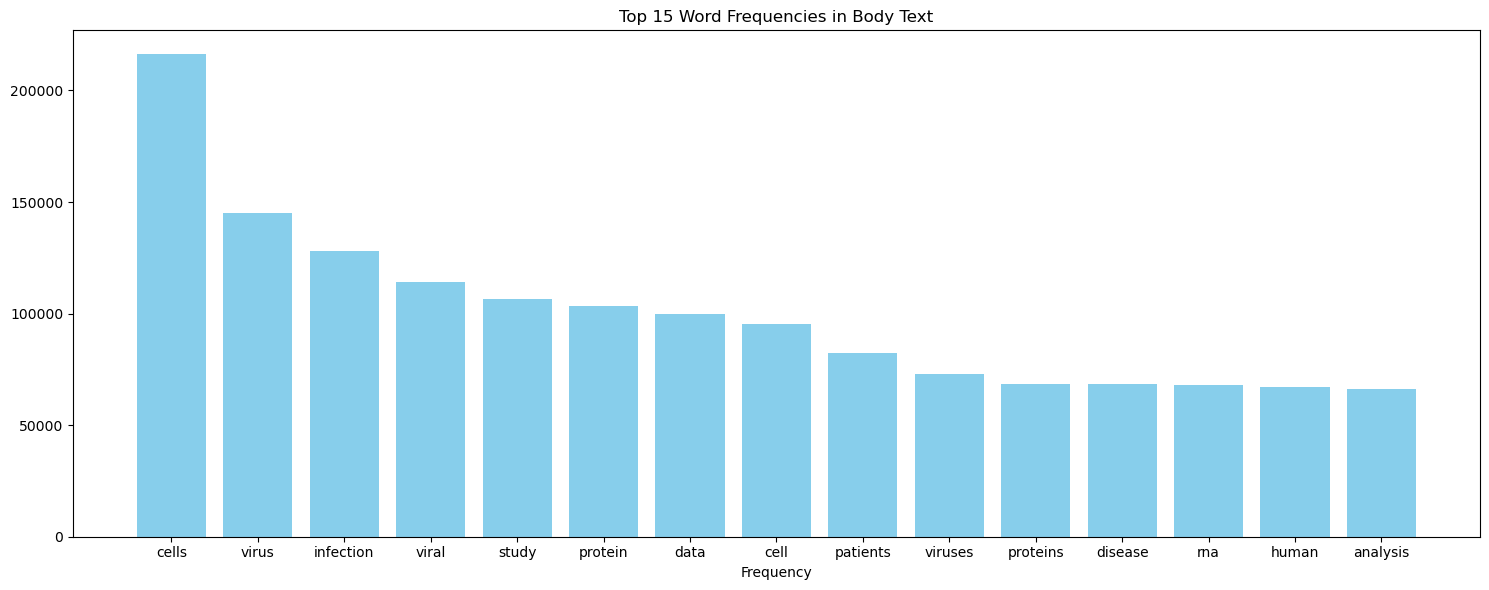

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.bar(words_array[::1], frequencies[::1], color='skyblue') 
plt.xlabel("Frequency")
plt.title("Top 15 Word Frequencies in Body Text")
plt.tight_layout()

plt.show()

We can do the same for the titles 

In [66]:
title_words = np.array(results_title)
print(title_words)

title_words_array = title_words[:, 0]
frequencies_title = title_words[:, 1].astype(int)

[['virus' '2138']
 ['respiratory' '1321']
 ['infection' '1172']
 ['influenza' '883']
 ['viral' '855']
 ['human' '836']
 ['coronavirus' '831']
 ['disease' '744']
 ['viruses' '681']
 ['analysis' '658']]


### Plotting the top 15 repeated words in titles 

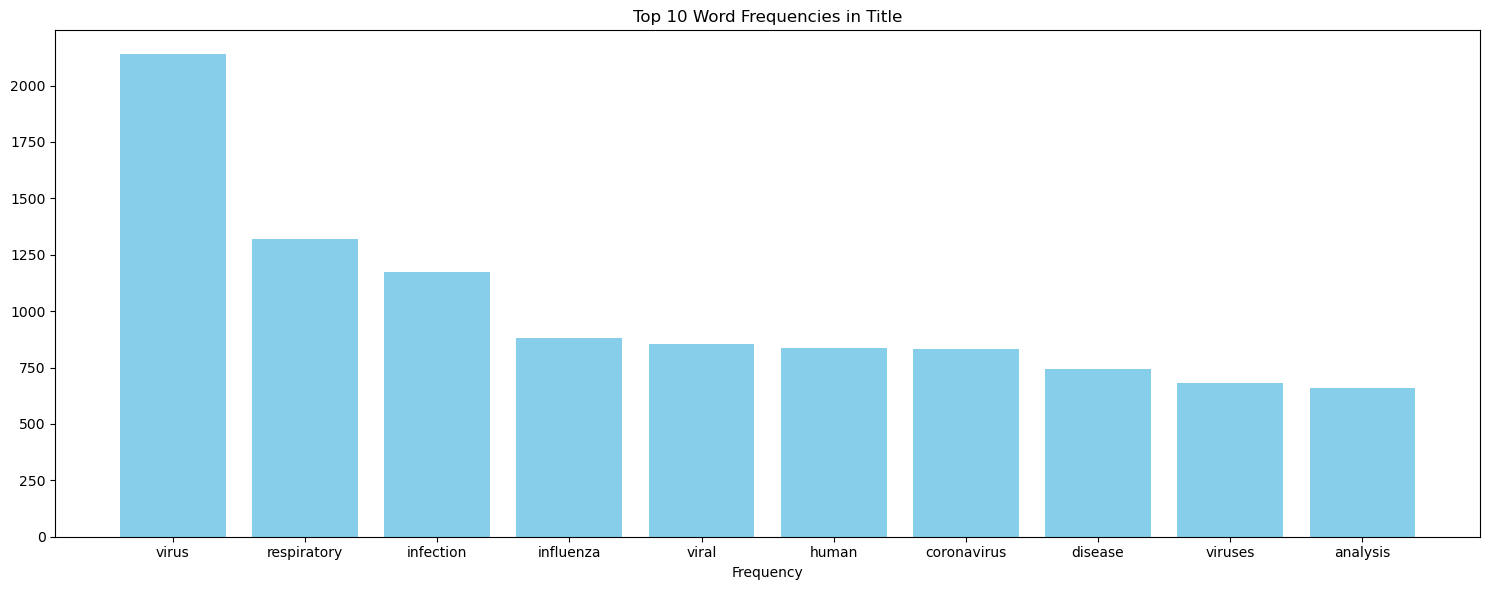

In [67]:
plt.figure(figsize=(15, 6))
plt.bar(title_words_array[::1], frequencies_title[::1], color='skyblue') 
plt.xlabel("Frequency")
plt.title("Top 10 Word Frequencies in Title")
plt.tight_layout()

plt.show()

## Which are the worst and best-represented countries/institutes in the research?

- For each document we access through `.pluck()` to the metadata and inside it `authors`

In [68]:
authors = bag.pluck("metadata").pluck("authors")
authors.take(3)

([{'first': 'Xueting',
   'middle': [],
   'last': 'Qiu1',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'University of Georgia',
    'location': {'settlement': 'Athens', 'region': 'GA'}},
   'email': 'xuetingqiu@hsph.harvard.edu'},
  {'first': 'Justin',
   'middle': [],
   'last': 'Bahl1',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'University of Georgia',
    'location': {'settlement': 'Athens', 'region': 'GA'}},
   'email': 'justin.bahl@uga.edu'}],
 [{'first': 'Haley',
   'middle': ['R'],
   'last': 'Harrington',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'Indiana University',
    'location': {'postCode': '47405',
     'settlement': 'Bloomington',
     'region': 'IN',
     'country': 'USA'}},
   'email': ''},
  {'first': 'Matthew',
   'middle': ['H'],
   'last': 'Zimmer',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'California Institute of Technology',
    'location': 

`take_authors` takes a single author dictionary and extracts structured affiliation and location information.


```json
{
  "affiliation_laboratory": "Padova Lab",
  "affiliation_institution": "University of Padova",
  "location_settlement": "Padova",
  "location_region": "Veneto",
  "location_country": "IT"
}

In [69]:
def take_authors(author):
    affiliation = author.get("affiliation", {})
    location = affiliation.get("location", {})
    return {
        "affiliation_laboratory": affiliation.get("laboratory", ""),
        "affiliation_institution": affiliation.get("institution", ""),
        "location_settlement": location.get("settlement", ""),
        "location_region": location.get("region", ""),
        "location_country": location.get("country", ""),
    }

`flattened_authors` Bag of cleaned flat dictionaries we convert it to a Dask Dataframe -> each dictionary becomes a row computing the results

In [70]:
create_authors_df_s_t = time.time()

flattened_authors = authors.flatten().map(take_authors)
df = flattened_authors.to_dataframe()
df.compute()

create_authors_df_e_t = time.time()
create_authors_df_time = create_authors_df_e_t - create_authors_df_s_t


`country_counts`: 
- counts occurrences of each country (`value_counts()`) and takes the top 20 most frequent (`nlargest(20)`)
- changue columns to `'location_country', 'count'`

In [71]:
country_counts = df['location_country'].value_counts().nlargest(20).compute()
country_counts = country_counts.reset_index()
country_counts.columns = ['location_country', 'count']
country_counts.head(20)

,location_country,count
0,,46871
1,China,9920
2,USA,6384
3,United States of America,2097
4,Japan,1659
5,UK,1640
6,Germany,1635
7,France,1579
8,Canada,1441
9,Italy,1143


We can observe that the same country have different names, the first case is for the United States that is also called USA or United States. We map this names as the same one 

So we clean up empty or inconsistent country names

In [72]:
counts_most_countries_s_t = time.time()
df['location_country'] = df['location_country'].str.strip().str.lower().replace('', 'no country')  

Define a mapping dictionary:

**Eg.** Whenever appears 'usa' standardize them all to 'united states'.

In [73]:
country_mapping = {
    'usa': 'united states',
    'united states of america': 'united states',
    'united states': 'united states',
    'uk': 'united kingdom',
    "people's republic of china": 'china',
    'korea': 'south korea',  
}

- Create a new column, `location_country_clean`, each value is replaced by the mapping if it exists, otherwise left unchanged.
- We compute again the number of counts of the cleaned version

In [74]:
df['location_country_clean'] = df['location_country'].replace(country_mapping)
country_clean = (
    df['location_country_clean']
    .value_counts()
    .nlargest(20)
    .compute()
    .reset_index()
)

country_clean.columns = ['location_country', 'count']
country_clean.head(20)

counts_most_countries_e_t = time.time()
counts_most_countries_time = counts_most_countries_e_t - counts_most_countries_s_t

### Plotting the top 19 participative countries

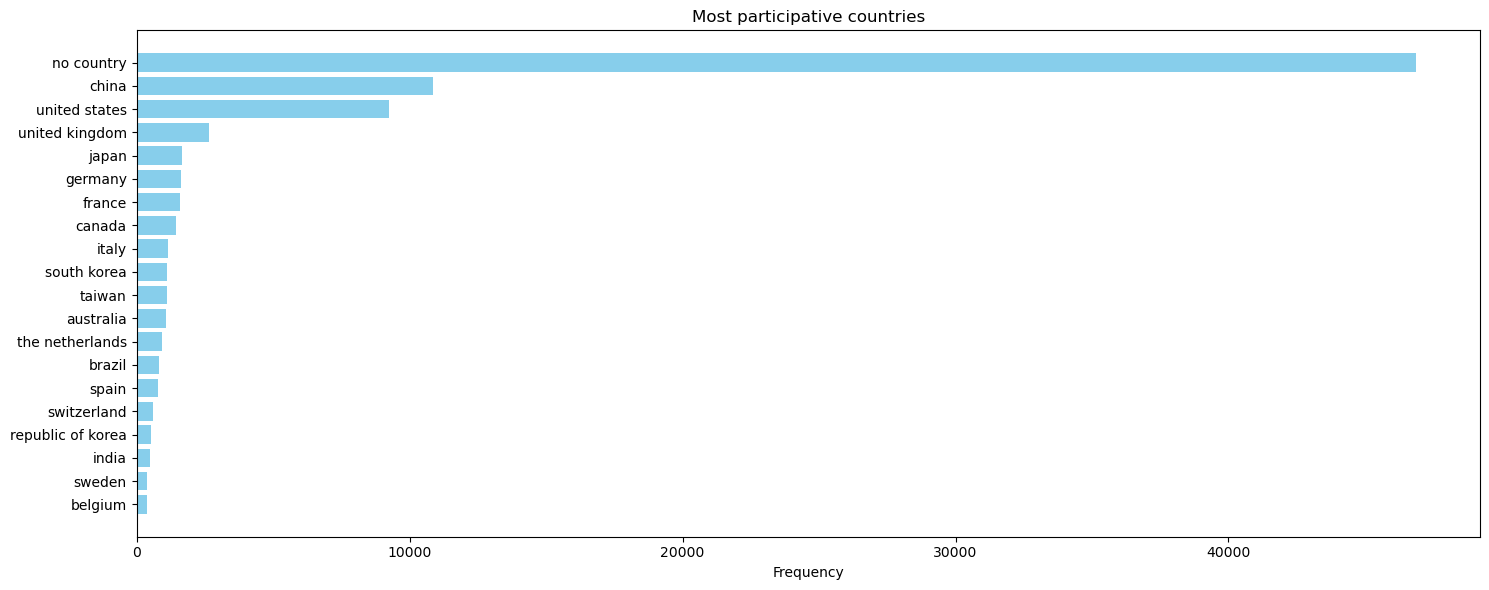

In [75]:
plt.figure(figsize=(15, 6))
plt.barh(country_clean['location_country'], country_clean['count'], color='skyblue') 
plt.xlabel("Frequency")
plt.title("Most participative countries")
plt.tight_layout()
plt.gca().invert_yaxis()

plt.show()

### Less participative countries

In [76]:
country_counts_less = df['location_country'].value_counts().nsmallest(20).compute()
country_counts_less = country_counts_less.reset_index()
country_counts_less.columns = ['location_country', 'count']
country_counts_less.head(20)

,location_country,count
0,china. 16,1
1,"belgium;, france",1
2,mcgovern,1
3,12 korea,1
4,korea article history,1
5,"sweden;, estonia;, denmark;, finland",1
6,"russia, spain",1
7,"germany, germany, germany",1
8,israel ¤a,1
9,"uk;, germany",1


### Affiliation Institutions

In [77]:
affiliation_counts_s_t = time.time()

affilitation_counts = df['affiliation_institution'].value_counts().nlargest(20).compute()
affilitation_counts = affilitation_counts.reset_index()
affilitation_counts.columns = ['affiliation_institution', 'count']
affilitation_counts.head(20)

affiliation_counts_e_t = time.time()
affiliation_counts_time = affiliation_counts_e_t - affiliation_counts_s_t

In [78]:
affilitation_counts = affilitation_counts.drop(index=0)

### Plotting the top 19 participative institutitons

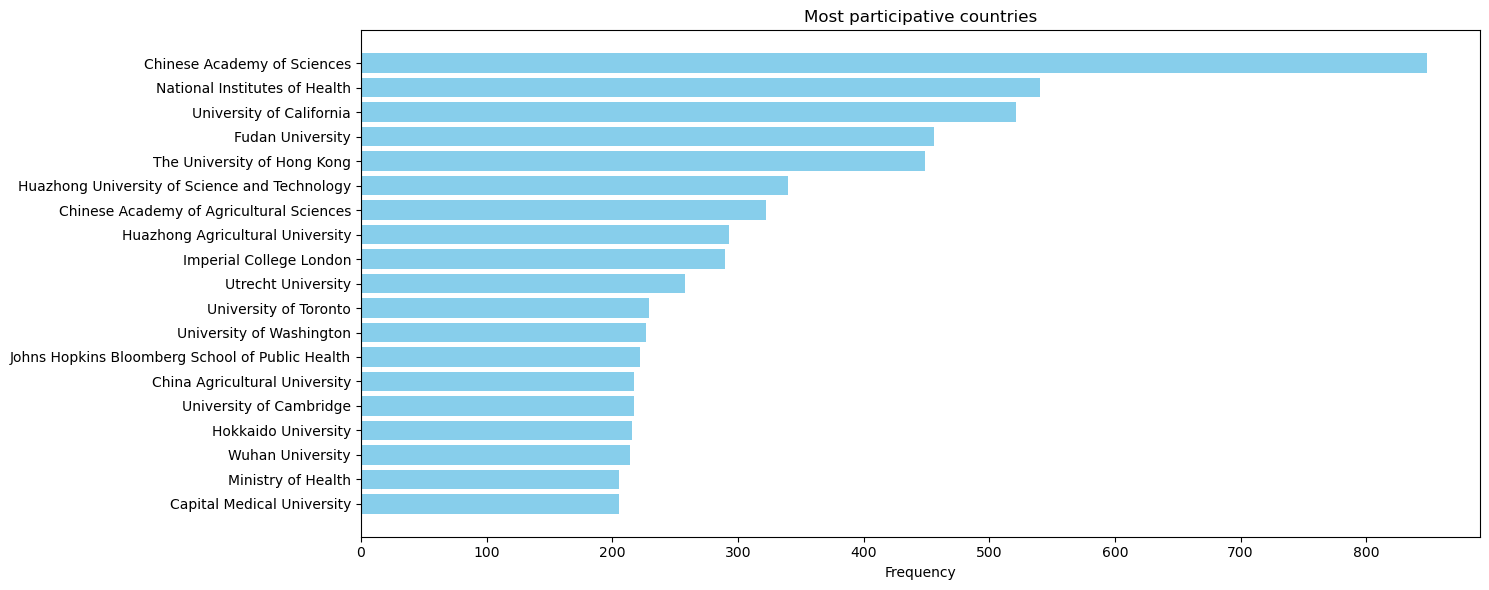

In [79]:
plt.figure(figsize=(15, 6))
plt.barh(affilitation_counts['affiliation_institution'], affilitation_counts['count'], color='skyblue') 
plt.xlabel("Frequency")
plt.title("Most participative countries")
plt.tight_layout()
plt.gca().invert_yaxis()

plt.show()

In [80]:
affilitation_counts_less = df['affiliation_institution'].value_counts().nsmallest(20).compute()
affilitation_counts_less = affilitation_counts_less.reset_index()
affilitation_counts_less.columns = ['affiliation_institution', 'count']
affilitation_counts_less.head(20)

,affiliation_institution,count
0,Agenzia Sanitaria e Sociale Regione Emilia-Rom...,1
1,FISABIO,1
2,Manchester Medical Microbiology Partnership,1
3,Sloan-Kettering Institute,1
4,"Teaching Institute of Public Health ""Dr. Andri...",1
5,Telethon Institute of Genetics and Medicine,1
6,Jingan Branch of Huashan Hospital Affiliated t...,1
7,"Shanghai Binuo Medical Instrument Co., Ltd",1
8,Universidad Nacional,1
9,Université Paris-Sud,1


### Plotting the top 19 less participative institutitons

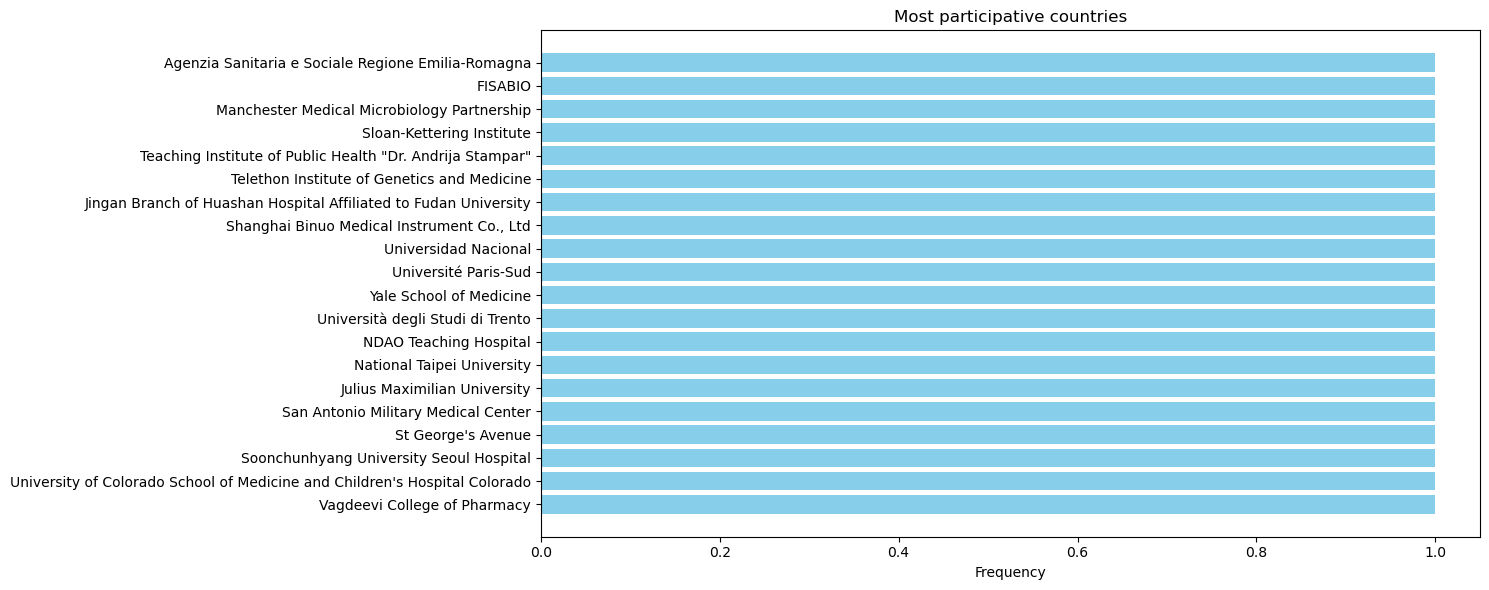

In [81]:
plt.figure(figsize=(15, 6))
plt.barh(affilitation_counts_less['affiliation_institution'], affilitation_counts_less['count'], color='skyblue') 
plt.xlabel("Frequency")
plt.title("Most participative countries")
plt.tight_layout()
plt.gca().invert_yaxis()

plt.show()

## Obtaining Embeddings for Paper Titles

- Transform text into numerical vectors, where each vector represents a word within a document.
- At the end of the embedding phase, the document is transformed into a list of vectors.
- The pre-trained model is essentially a large dictionary in the format `key: vector`, we will use the best pretrained model `wiki.en.vec`

### Word Embedding: One-Hot vs Word2Vec

- **Vocabulary (V)**: Set of all unique words in a dataset.
- **Embedding**: A numeric vector representing a word, ideally capturing its meaning.
- **Vector Space**: Multidimensional space where words are positioned based on semantic similarity.
- **Distributed Representation**: Word encoding that reflects contextual relationships.

**One-Hot Encoding**

- Represents each word as a binary vector with a single `1` and all other positions `0`.
- The vector length equals the vocabulary size.
  - No semantic relationship between words—each word is treated as isolated and unrelated.

**Word2Vec**

- Capture meaning and context.
- Learns relationships based on word co-occurrence in textual context.
- Two training architectures:
  - **CBOW**: Predicts a word from its surrounding context.
  - **Skip-Gram**: Predicts surrounding words from a target word.
- Uses backpropagation and neural networks to learn word embeddings.


In [82]:
import os 

print("Working directory:", os.getcwd())
print("File exists:", os.path.exists("/shared/data/models/wiki.en.vec"))

Working directory: /home/ubuntu
File exists: True


We create a reduced Dask Bag (bag) of JSON documents.

In [83]:
#We reduce the size of the file 

files = glob.glob("/shared/data/biorxiv_medrxiv/biorxiv_medrxiv/*.json")
bag = db.from_sequence(files, npartitions=partitions).map(load_json_from_path).filter(lambda x: x is not None)

`load_vectors_dask(fname_path)`:
- Used to read the pretrained model (6 GB) in parallel
- Gets vocabulary size (n) and vector dimension (d) from the first line
- Removes the header line
- Parse each line into `(word, vector)` pairs through an internal function `parse_line(line)`
- Creates a Dask Bag of clean (word, vector) pairs.

We can perform a grid search in the blocksize when loading the model for determining the best number of partitions because our pretrained model is too large (6 GB).

In [84]:
# import dask.bag as db
# import time
# import csv

# fasttext_model_path = '/shared/data/models/wiki.en.vec'
# results = []

# blocksizes = ["128MB", "64MB", "32MB", "16MB", "8MB", "4MB"]

# for bsize in blocksizes:
#     print(f"\nLoading with blocksize={bsize}")
#     start_t = time.time()
#     bag = load_vectors_dask_blocksize(fasttext_model_path, bsize)
#     count = bag.count().compute()
#     end_t = time.time()
#     elapsed = end_t - start_t
#     n_partitions = bag.npartitions
#     print(f"Blocksize: {bsize}, Partitions: {n_partitions}, Count: {count}, Load time: {elapsed:.2f} s")
#     results.append({
#         'blocksize': bsize,
#         'n_partitions': n_partitions,
#         'load_time_sec': elapsed
#     })

# csv_file = 'load_times_blocksize.csv'
# with open(csv_file, 'w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=['blocksize', 'n_partitions', 'load_time_sec'])
#     writer.writeheader()
#     for row in results:
#         writer.writerow(row)

# print(f"\nResults saved to {csv_file}")

In [85]:
df = pd.read_csv('load_times_blocksize.csv')

print(df.to_string(index=False))

blocksize  n_partitions  load_time_sec
    128MB            51      78.316628
     64MB           103      64.767652
     32MB           206      60.735220
     16MB           412      58.491894
      8MB           824      55.900940
      4MB          1649      53.449924


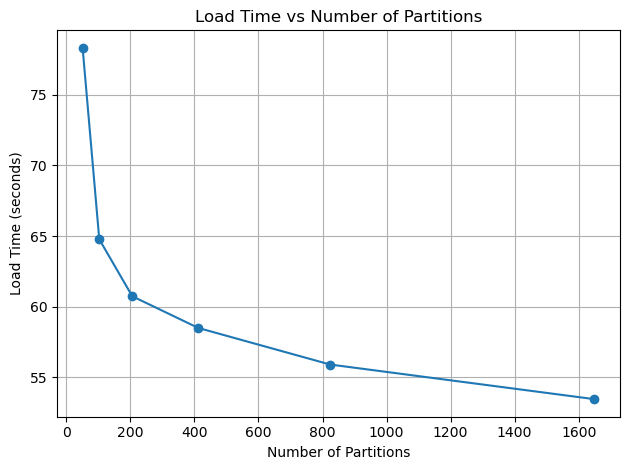

In [86]:
import csv
import matplotlib.pyplot as plt

x = [] 
y = []  

with open('load_times_blocksize.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        x.append(int(row['n_partitions']))
        y.append(float(row['load_time_sec']))

plt.plot(x, y, marker='o')
plt.xlabel('Number of Partitions')
plt.ylabel('Load Time (seconds)')
plt.title('Load Time vs Number of Partitions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
load_wiki_en_vec_s_t = time.time()
def load_vectors_dask(fname_path):
    vec_bag = db.read_text(fname_path, blocksize="8MB")
    header_line = vec_bag.take(1)[0]
    n, d = map(int, header_line.split())
    print(f"Detected vocabulary size (n): {n}, vector dimension (d): {d}")

    data_bag = vec_bag.map_partitions(
        lambda partition: [line for line in partition if line != header_line]
    )

    def parse_line(line):
        tokens = line.rstrip().split(' ')
        if len(tokens) == d + 1:
            return tokens[0], list(map(float, tokens[1:]))
        return None 
    word_vectors_bag = data_bag.map(parse_line).filter(lambda x: x is not None)

    return word_vectors_bag


fasttext_model_path = '/shared/data/models/wiki.en.vec'

dask_model_bag = load_vectors_dask(fasttext_model_path)
print(f"Number of partitions: {dask_model_bag.npartitions}")

load_wiki_en_vec_e_t = time.time()
load_wiki_en_vec_time = load_wiki_en_vec_e_t - load_wiki_en_vec_s_t

Detected vocabulary size (n): 2519370, vector dimension (d): 300
Number of partitions: 824


Compute all the tokens from all titles in a single Bag of strings


In [88]:
titles = bag.pluck("metadata").pluck("title").map(clean_text)  
titles_tokens = titles.flatten()  #All the titles tokens in one bag
unique_tokens = set(titles_tokens.distinct().compute())   #Reduce the dimension of the vector using the unique words

- Filter the vector bag to keep only words in your vocabulary `unique_tokens` converting it to a dictionary
- This will be our embedding lookup table, $V = 300$

In [89]:
create_dictionary_s_t = time.time()
import numpy as np
vectors_bag = dask_model_bag.filter(lambda x: x[0] in unique_tokens)
vectors_dict = dict(vectors_bag.compute())

create_dictionary_e_t = time.time()
create_dictionary_time = create_dictionary_e_t - create_dictionary_s_t



`embed_title` takes as input the list of cleaned tokens from a title and the dictionary to lookup

- For each token, get its vector from `vectors_dict`, if the token doesn't appear we skip it
- We average all the word vectors to create a single 300-dimensional vector representing the title.

In [90]:
embedding_s_t = time.time()

def embed_title(tokens, vectors_dict):
    embeddings = [vectors_dict[token] for token in tokens if token in vectors_dict]
    if not embeddings:
        return np.zeros(300) 
    return np.mean(embeddings, axis=0)

title_embeddings = titles.map(lambda tokens: embed_title(tokens, vectors_dict))
title_embeddings.take(5)

embedding_e_t = time.time()
embedding_time = embedding_e_t - embedding_s_t

Now, we have a vector of dimesion 300 for each title, we can join this in another bag. In bag the elements are ordenate, so we can just *zip* them 

In [91]:
id_bag = bag.pluck("paper_id")
id_titles_em = db.zip(id_bag, title_embeddings)  #Join the title embeddings with the paper_id
id_titles_em.take(1)

(('75216c0238ddc17dec8ef66adcc84bd48922cae4',
  array([-0.02265751,  0.00631214, -0.2166295 ,  0.22229835, -0.14725564,
          0.09682757,  0.07881043, -0.26256343, -0.07685583,  0.08998017,
          0.11709964,  0.20252571, -0.26892179,  0.07070343, -0.0287813 ,
         -0.30961286,  0.00836799, -0.06473759,  0.13115136,  0.40510336,
          0.14980293,  0.03539664, -0.12560429, -0.19323271, -0.18057367,
         -0.15519793,  0.03096936,  0.01694802, -0.08679619,  0.13078763,
         -0.05094371,  0.24865317, -0.26636329,  0.31059114,  0.03200374,
          0.055262  ,  0.15932279,  0.17340634,  0.02970021,  0.01671448,
         -0.01971401, -0.12677114,  0.13647236,  0.01489071,  0.053654  ,
          0.05709877,  0.18750364, -0.015393  ,  0.31017029, -0.11719214,
          0.03034871, -0.17392407, -0.19395936, -0.28114893, -0.09365643,
         -0.04243745, -0.05180114,  0.15207179, -0.05035214,  0.26996071,
         -0.018654  , -0.09520307,  0.12470607, -0.07745912, -0.07

## Cosine Similarity 

- Computes the cosine similarity between two vectors v1 and v2.

- Measures how close two vectors point in the same direction (ranges from -1 to 1).

- Used here to compare text embeddings and find semantic similarity between paper titles.


First, we can compare with one title over the rest of the titles in the embedding, this will let us know if the functions are working 

In [92]:
cosine_sim_bag_s_t = time.time()


import numpy as np

def cosine_sim(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

titles = bag.pluck("metadata").pluck("title").map(clean_text)
title_tok=titles.take(1)
titles=np.array(title_tok)

titles = ['structurally', 'informed', 'evolutionary', 'models', 'improve',
        'phylogenetic', 'reconstruction', 'emerging', 'seasonal',
        'pandemic', 'influenza', 'viruses', 'corresponding', 'authors']

query_embedding = embed_title(titles, vectors_dict)

similarity = id_titles_em.map(
    lambda pair: (pair[0], cosine_sim(pair[1], query_embedding)))

results = similarity.compute(npartitions=partitions) 

top_results = sorted(results, key=lambda x: x[1], reverse=True)[:10]
print(top_results)

cosine_sim_bag_e_t = time.time()
cosine_sim_bag_time = cosine_sim_bag_e_t - cosine_sim_bag_s_t


[('75216c0238ddc17dec8ef66adcc84bd48922cae4', 1.0), ('58fd342d5c70641bd4e72aa822f0e532c0127ca3', 0.8700880006843441), ('44a440cc1c135c938d2216ea672f8ef4f9c01296', 0.8334485336894346), ('164b0678afc42f1923aa100b624ca969a53fb3b2', 0.8261176885544472), ('107f0d5a47f48f85d6645cac0e7008edc4d9d8cd', 0.8202867927930526), ('584b43ae1d473b93ad7b6c95d681e8f356ba82cd', nan), ('36e602b7081e7bb8a1cfeaa2fb92b0c43abd4fef', 0.8217092069215184), ('d5a1fed3fc7baf4e31c897ec639995106e9fae78', 0.8191799388325471), ('8a1fde8c65e439496ac5810504de23ef77312f28', 0.8175751093046414), ('ca950c8677b72b5c4812be3f7d082029df3c12ea', 0.812046448537566)]


To make easily how to compare all the pair titles, we convert into a dataframe 

In [93]:
embedding_df_s_t = time.time()

id_titles_df = id_titles_em.to_dataframe(meta=[('paper_id', str), ('embedding', object)])

embedding_df_e_t = time.time()
embedding_df_time = embedding_df_e_t - embedding_df_s_t


In [94]:
id_titles_df.head(5)


,paper_id,embedding
0,75216c0238ddc17dec8ef66adcc84bd48922cae4,"[-0.022657507142857147, 0.006312142857142862, ..."
1,7837a1b529936ac78b802e41daa73ddab8bfc41a,"[0.03502128888888889, -0.04161944444444446, -0..."


In [95]:
import pandas as pd

def flatten_embeddings(df):
    # Convert list-of-arrays to 2D numpy
    emb_array = np.vstack(df["embedding"].to_numpy())
    columns = [f"emb_{i}" for i in range(emb_array.shape[1])]
    
    flat_df = pd.DataFrame(emb_array, columns=columns, index=df.index)
    flat_df["paper_id"] = df["paper_id"].values
    
    return flat_df

In [96]:
new_meta = pd.DataFrame({
    **{f'emb_{i}': pd.Series(dtype='float64') for i in range(300)},
    'paper_id': pd.Series(dtype='str')
})

In [97]:
flat_df = id_titles_df.map_partitions(flatten_embeddings, meta=new_meta)

In [98]:
convert_to_parquet_s_t = time.time()

flat_df = flat_df.repartition(npartitions=25)
flat_df.to_parquet("/shared/data/parsed_titles_embeddings/")

convert_to_parquet_e_t = time.time()
convert_to_parquet_time = convert_to_parquet_e_t - convert_to_parquet_s_t   


In [99]:
new_df = pd.read_parquet("/shared/data/parsed_titles_embeddings/")
new_df.head(5)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,paper_id
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,-0.022658,0.006312,-0.216630,0.222298,-0.147256,0.096828,0.078810,-0.262563,-0.076856,0.089980,...,-0.107088,0.113485,0.065938,-0.074750,-0.141235,-0.115652,0.220235,0.188254,-0.196789,75216c0238ddc17dec8ef66adcc84bd48922cae4
1,0.035021,-0.041619,-0.440081,0.281602,-0.327278,-0.056693,0.330100,-0.070839,-0.273284,-0.238560,...,-0.384601,0.053748,-0.009890,0.022588,-0.153128,-0.160100,0.292070,0.172882,-0.363823,7837a1b529936ac78b802e41daa73ddab8bfc41a
0,0.026459,-0.023431,-0.204995,0.312358,-0.157776,0.082006,0.040323,-0.169871,0.010432,0.083325,...,0.007522,-0.006543,-0.120635,-0.042044,-0.121241,-0.034594,0.050866,0.134491,-0.165202,013d9d1cba8a54d5d3718c229b812d7cf91b6c89
1,0.078358,0.015563,-0.121243,0.292947,-0.023402,0.091021,-0.013784,-0.484300,0.053157,0.050527,...,0.021187,0.179833,-0.123436,-0.013770,0.016800,-0.131050,0.115876,0.165204,-0.271164,7344c6de7ce2258e74ce131bed72e6ad465f0ce8
0,-0.071897,0.044057,-0.081790,0.243119,-0.158192,0.114011,-0.018603,-0.354034,-0.007496,0.144372,...,-0.077875,0.125155,-0.068098,0.019105,-0.168831,-0.059318,0.044152,0.029252,-0.090822,b9c285b9be5524a8d241c0a32a1cb1ef9df155f6


In [100]:
id_column = 'paper_id'  
embedding_columns = new_df.columns.drop(id_column)
embeddings = new_df[embedding_columns].values
ids = new_df[id_column].values

In [101]:
#Cosine similarity using matrix multiplication
from numpy.linalg import norm
def cosine_similarity_matrix(matrix, vector):
    matrix_norms = norm(matrix, axis=1)
    vector_norm = norm(vector)
    dots = matrix @ vector
    return dots / (matrix_norms * vector_norm + 1e-8)



In [102]:
cosine_simM_one_title_s_t = time.time()
similarities = cosine_similarity_matrix(embeddings, query_embedding)

# Top results
top_n = 5
top_indices = np.argsort(similarities)[-top_n:][::-1]
for idx in top_indices:
    print(f"ID: {ids[idx]}, Score: {similarities[idx]:.4f}")

cosine_simM_one_title_e_t = time.time()
cosine_simM_one_title_time = cosine_simM_one_title_e_t - cosine_simM_one_title_s_t

ID: 75216c0238ddc17dec8ef66adcc84bd48922cae4, Score: 1.0000
ID: ccaafc13b2c1551dce74e1a7fe3e43cea5228732, Score: 0.8778
ID: 5b97940d7cbe82e8c8b2482f6d6ab6fd45ecdbb1, Score: 0.8775
ID: 965f06d2f9a87b69f59b1656c979e04eaa5d75be, Score: 0.8724
ID: 965f06d2f9a87b69f59b1656c979e04eaa5d75be, Score: 0.8724


In [103]:
top_n = 5
top_indices = np.argsort(similarities)[:5]
for idx in top_indices:
    print(f"ID: {ids[idx]}, Score: {similarities[idx]:.4f}")

ID: bab88fad90f0f0448f75af01145e2f1b90412527, Score: 0.0000
ID: 584b43ae1d473b93ad7b6c95d681e8f356ba82cd, Score: 0.0000
ID: b89434ac6bfe4104f4c207a770a6858413e383cd, Score: 0.0000
ID: d7732a3cb93e9f48792f9072956ef244552afca1, Score: 0.0000
ID: 67a530bb1b7075edffe904df66644b0a1da97d1f, Score: 0.0000


### For all papers

Knowing this, we can expand the calculation for all the papers. Now we will have a matrix of NxN 

In [104]:
cosine_simM_all_s_t = time.time()

norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
emb_normed = embeddings / (norms + 1e-8) 

cosine_sim_matrix = emb_normed @ emb_normed.T

N = cosine_sim_matrix.shape[0]
mask = ~np.eye(N, dtype=bool)  #We remove the diagonal because is always 1 

# Upper diagonal indices
rows, cols = np.triu_indices_from(cosine_sim_matrix, k=1)
similarities = cosine_sim_matrix[rows, cols]

# top 5
top_n = 10
top_indices_flat = np.argsort(similarities)[-top_n:][::-1]

rows, cols = np.where(mask)
for k in top_indices_flat:
    i = rows[k]
    j = cols[k]
    print(f"{ids[i]} <-> {ids[j]} : similarity {similarities[k]:.6f}")

cosine_simM_all_e_t = time.time()
cosine_simM_all_time = cosine_simM_all_e_t - cosine_simM_all_s_t

34d485e6c776b7e4e28bab88bdd133aa4d43e4b2 <-> 975a8b4abe4cc0181522e859a92c5ddc22f50c29 : similarity 1.000000
01de46a248049d2fbdc049b686ee5b172301d0fa <-> b29af8a410b032d1159bf9cefe0654c43f3503d9 : similarity 1.000000
bfa1dab8c91f41f59df39489115a8b2e19e537bf <-> c2d4efc02a8e37fb93eafe7ddb9eff42e0c600b2 : similarity 1.000000
bfa1dab8c91f41f59df39489115a8b2e19e537bf <-> 4b55b2415bd2adff96e6013f792d281693bf4587 : similarity 1.000000
34d485e6c776b7e4e28bab88bdd133aa4d43e4b2 <-> fb968c1fb602f50dd434c8a7cb28129c3a7a4217 : similarity 1.000000
bfa1dab8c91f41f59df39489115a8b2e19e537bf <-> 1f541a086ac9bc30df8ee2060f958691fb4a0667 : similarity 1.000000
41d42af9e99779958c80165b6958a1cbeba023a9 <-> 1376526470f18216200ecd6c375d9913942fa362 : similarity 1.000000
84388602b1574ebc0b2cdffa1d5ea4ec5ba22b40 <-> 53fa60a93898a5901b87fe8ad651ac5f75611071 : similarity 1.000000
8ae4a09bc3001554f0639e2b139ee2565fe1aad3 <-> 0134717f1b5ea99fc7e5ac305d492f5cedc8cd92 : similarity 1.000000
7852aafdfb9e59e6af78a47af796

In [105]:
bottom_n = 10
bottom_indices_flat = np.argsort(similarities)[:bottom_n]

for k in bottom_indices_flat:
    i = rows[k]
    j = cols[k]
    print(f"{ids[i]} <-> {ids[j]} : similarity {similarities[k]:.6f}")

247a9eae1e4452f7f969ab41a88f335fda54fbc9 <-> 17fd86bef40a55871ecfc83dc845f3a988bf4aaa : similarity 0.000000
17bfdf17f46ae63e52c3e7c085bac97057e9ae61 <-> 5a3f46d6fe292e51aa8ad833905cd913ade65caa : similarity 0.000000
17bfdf17f46ae63e52c3e7c085bac97057e9ae61 <-> 27548472c288a185911a8907c927d18f3c9b0abe : similarity 0.000000
d7df17379b5a79dd5917ea5f26051eef8bfe5011 <-> cff7fb355c096e08503caf3108f7b01525318634 : similarity 0.000000
d7df17379b5a79dd5917ea5f26051eef8bfe5011 <-> 737650f6ab6664da7582430d4b45ff9dd2e76866 : similarity 0.000000
17bfdf17f46ae63e52c3e7c085bac97057e9ae61 <-> 011b8a7002da6c0fae7ca76c127567a6462daf5d : similarity 0.000000
10424da2599f0258bfaf71a3186b999ab2d747d0 <-> e2d29009210b2e9a2e3273cb541c7298b1bbb3cb : similarity 0.000000
1c02f14de3ae4c5e26600b073ec6396caefb3830 <-> 28d395784208073fa0bd75540cfed74a2018061d : similarity 0.000000
10424da2599f0258bfaf71a3186b999ab2d747d0 <-> 0f34670b6327305bb3d66de79d1aa96a5d8de2b2 : similarity 0.000000
d7df17379b5a79dd5917ea5f2605

Adding new configuration in benchmarking

In [106]:
new_result = pd.DataFrame([{
        'num_workers' : len(client.scheduler_info()['workers']),
        'num_partitions': partitions,
        'load_data_time': load_data_time,
        'clean_count_time': clean_count_time,
        'extract_full_text_time': extract_full_text_time,
        'embedding_time': embedding_time,
        'cosine_sim_bag_time': cosine_sim_bag_time,
        'embedding_df_time': embedding_df_time,
        'convert_to_parquet_time': convert_to_parquet_time,
        'cosine_simM_one_title_time': cosine_simM_one_title_time,
        'cosine_simM_all_time': cosine_simM_all_time
    }])

all_benchmark_results = pd.concat([all_benchmark_results, new_result], ignore_index=True) #adding new results

all_benchmark_results.to_csv(csv_file, index=False) #saving

In [107]:
import pandas as pd

df = pd.read_csv('benchmark_results.csv')

time_cols = [col for col in df.columns if col.endswith('_time')]
df['total_time'] = df[time_cols].sum(axis=1)

summary_df = df[['num_workers', 'num_partitions', 'total_time']]

print(summary_df.to_string(index=False))



 num_workers  num_partitions  total_time
           3              25   54.668230
           3              50   46.630576
           3             100   70.442575
           3             200   94.631785
           3             500  179.234446
           3             800  327.360029
           2              25   53.400492
           2              50   57.885226
           2             100   80.258003
           2             200  120.057074
           2             500  213.427623
           2             800   54.201944
           1              25  139.612898
           1              50   63.876723
           1             100   87.654300
           1             200   94.825409
           1             500  102.049519
           1             800  106.125973
           3             500  168.862534


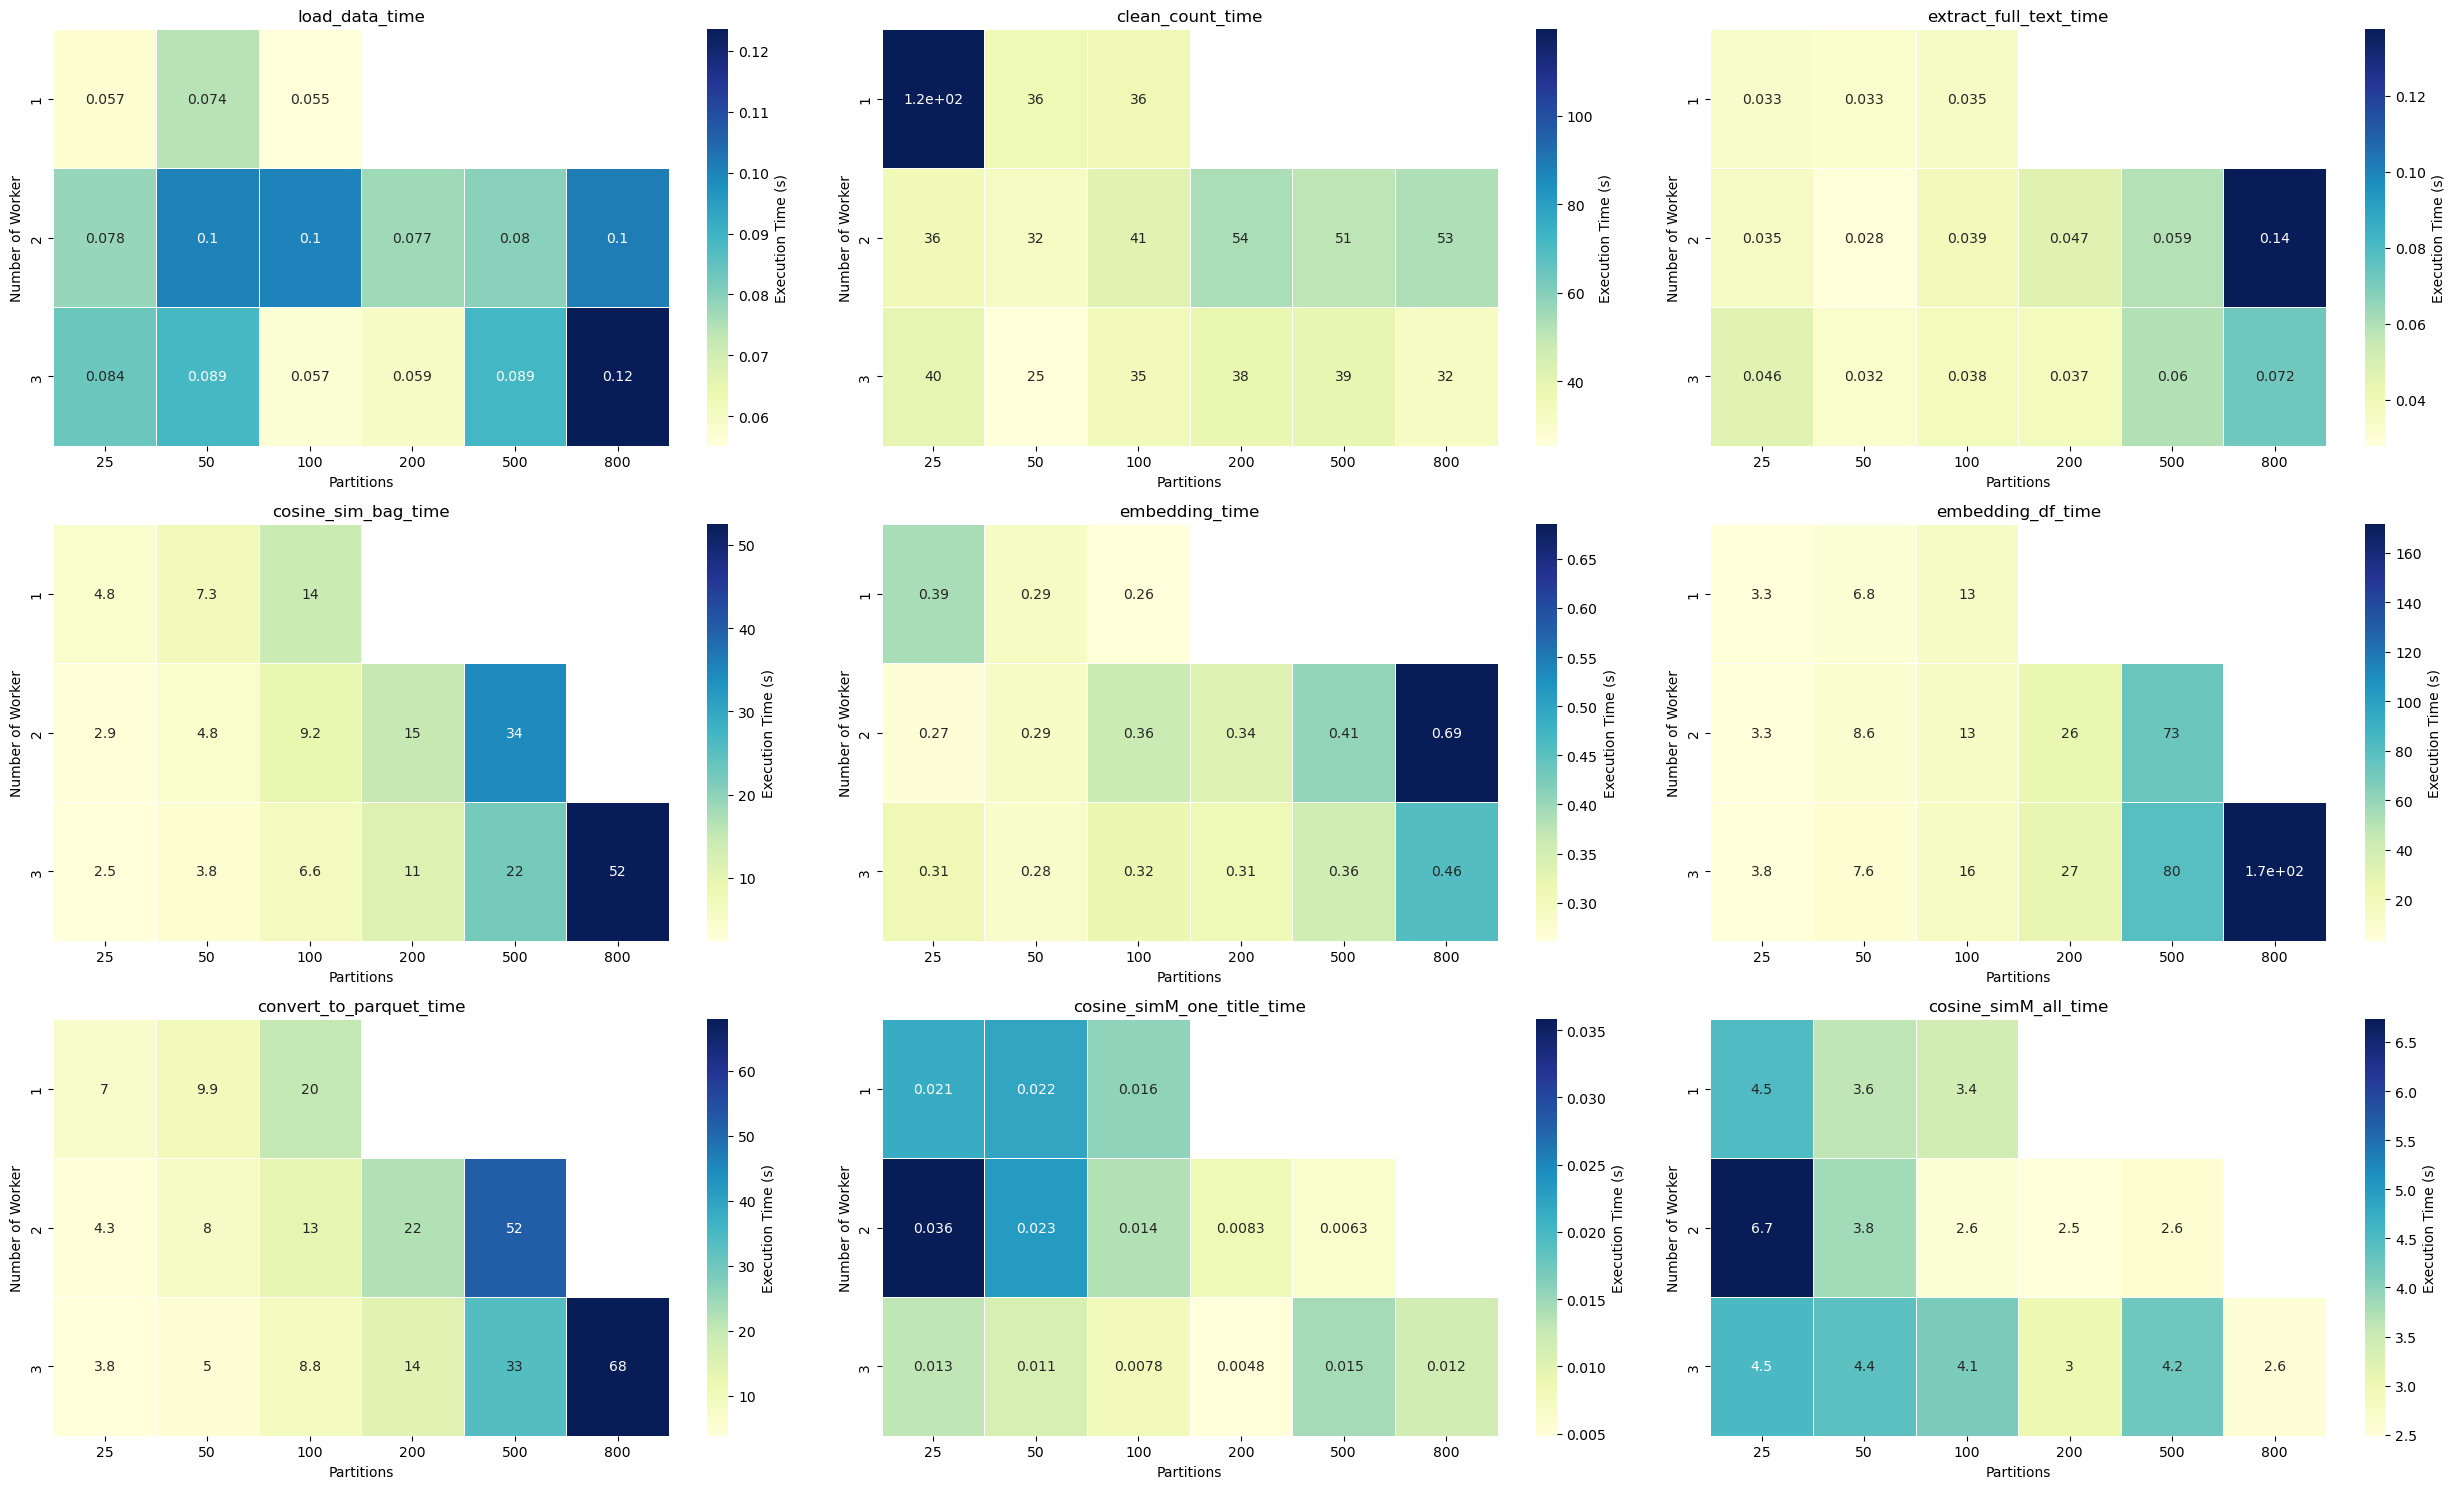

In [110]:
import seaborn as sns

# Load the CSV file
df = pd.read_csv('benchmark_results.csv')

#drop some extreme cases that were computed but as they have very long times they compromise the results of the heatmaps
df = df.drop(df.index[15:20])

# Define the task categories
time_categories = ['load_data_time', 'clean_count_time', 'extract_full_text_time', 'cosine_sim_bag_time', 'embedding_time', 'embedding_df_time', 'convert_to_parquet_time', 'cosine_simM_one_title_time', 'cosine_simM_all_time']


fig, axes = plt.subplots(3, 3, figsize=(25, 15))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Creation of heatmap for each task
for i, task_time in enumerate(time_categories):
    # Pivot the dataframe for each time category based on cores and partitions
    task_pivot = df.pivot(index="num_workers", columns="num_partitions", values=task_time)
    
    # Create a heatmap for the current task_time in the appropriate subplot
    sns.heatmap(task_pivot, annot=True, cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Execution Time (s)'}, ax=axes[i])
    
    # Set titles and labels
    axes[i].set_title(task_time)
    axes[i].set_xlabel('Partitions')
    axes[i].set_ylabel('Number of Worker')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

STOP AND CLOSE THE CLUSTER

In [109]:
cluster.close()
client.close()